In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 2.1MB 8.5MB/s 
     |████████████████████████████████| 102kB 11.0MB/s 
     |████████████████████████████████| 163kB 38.0MB/s 
     |████████████████████████████████| 133kB 37.1MB/s 
     |████████████████████████████████| 71kB 7.0MB/s 


In [ ]:
import pandas as pd
import numpy as np
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

random_state=42

tf.random.set_seed(random_state)

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Major Project/data/central_data/cleaned.csv")
print(df.columns, df.shape)
columns_list = ['Daily Confirmed']

Index(['Day', 'public_information_campaigns', 'stay_home_requirements',
       'close_public_transport', 'cancel_public_events', 'testing_policy',
       'stringency_index', 'vaccination_policy', 'facial_coverings',
       'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated',
       'mobility_driving', 'mobility_walking', 'retail_and_recreation',
       'grocery_and_pharmacy', 'residential', 'transit_stations', 'parks',
       'workplaces', 'Daily Confirmed', 'Total Confirmed', 'Daily Recovered',
       'Total Recovered', 'Daily Deceased', 'Total Deceased'],
      dtype='object') (456, 26)


In [ ]:
# 7-day averaging
df_7 = pd.DataFrame(columns=columns_list)
for col in df.columns:
  if col == "Day":
    continue
  li=[]
  for i in range(df.shape[0]-7):
    li.append(np.mean(df[col][i:i+7]))
  df_7[col] = li
print(df_7.shape)

(449, 25)


In [ ]:
# Data Preprocessing

ts_data = df_7.loc[100:, columns_list]
sc = MinMaxScaler(feature_range = (0, 1))
test_num=-56
# Split into testing and training: Last 56 days to test
train_ts_raw = ts_data[:test_num] # 425 dates
train_ts = pd.DataFrame(columns=columns_list)

# Scaling
scalers={}
for i in ts_data.columns:
    if i=='Daily Confirmed':
        scaler = MinMaxScaler(feature_range=(0,1))
    else:
        scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train_ts_raw[i].values.reshape(-1,1))
    s_s = np.reshape(s_s, len(s_s))
    scalers['scaler_'+ i] = scaler
    train_ts[i]=s_s


ts_data_scaled = pd.DataFrame(columns=columns_list)
test_ts = pd.DataFrame(columns=columns_list) 

for i in ts_data.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(ts_data[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    ts_data_scaled[i]=s_s

for i in ts_data.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(ts_data[test_num:][i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    test_ts[i]=s_s
print(train_ts.shape, test_ts.shape)


(293, 1) (56, 1)


In [ ]:
# The expected shape for a rnn is [batch, timesteps, features]. 

timesteps=14
batch=train_ts.shape[0]-timesteps
features=len(columns_list)

# Preparing the dataset
X_train = np.zeros((batch, timesteps, features))
for i in range(batch):
  X_train[i] = train_ts[i:i+timesteps]

print(X_train.shape)

(279, 14, 1)


In [ ]:
# y_train data setup
y_train = train_ts.loc[:, "Daily Confirmed"][-batch:]
print(y_train.shape)

(279,)


In [ ]:
# Similarly do for test data
batch_test = test_ts.shape[0]
X_test = np.zeros((batch_test, timesteps, features))
for i in range(batch_test):
  X_test[i] = ts_data_scaled[-timesteps-batch_test+i:-batch_test+i]
print(X_test.shape)

y_test = test_ts.loc[:, "Daily Confirmed"][-(batch_test):]
print(y_test.shape)

(56, 14, 1)
(56,)


In [ ]:
# Creating the model

model = keras.models.Sequential()
model.add(keras.layers.LSTM(128, input_shape=(timesteps,features), return_sequences=True))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.LSTM(128, return_sequences=True))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.LSTM(128, return_sequences=False))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(1))

model.summary()

# 1. Start a new run
wandb.init(project='final_outputs_csv', entity='covid19india')

# 2. Save model inputs and hyperparameters
config = wandb.config
config.timesteps=timesteps
config.test_num = test_num
config.batch = batch
config.features = features
config.columns = columns_list
config.random_state = random_state
config.model = model

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 14, 128)           66560     
_________________________________________________________________
dropout_6 (Dropout)          (None, 14, 128)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 14, 128)           131584    
_________________________________________________________________
dropout_7 (Dropout)          (None, 14, 128)           0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

epoch,19
loss,0.04907
root_mean_squared_error,0.06744
mean_absolute_error,0.04907
_runtime,21
_timestamp,1619799547
_step,20


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
root_mean_squared_error,█▆▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▇█
_timestamp,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▇█
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██


In [ ]:
# Compiling the model
opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='mean_absolute_error', metrics=[keras.metrics.RootMeanSquaredError(), keras.metrics.MeanAbsoluteError()])

In [ ]:
# 3. Log layer dimensions and metrics over time
history = model.fit(X_train, y_train, epochs=20, batch_size=20, callbacks=[WandbCallback()])

Epoch 1/20
14/14 [==============================] - 6s 56ms/step - loss: 0.3608 - root_mean_squared_error: 0.4447 - mean_absolute_error: 0.3608
Epoch 2/20
14/14 [==============================] - 1s 50ms/step - loss: 0.2325 - root_mean_squared_error: 0.3061 - mean_absolute_error: 0.2325
Epoch 3/20
14/14 [==============================] - 1s 52ms/step - loss: 0.0920 - root_mean_squared_error: 0.1075 - mean_absolute_error: 0.0920
Epoch 4/20
14/14 [==============================] - 1s 50ms/step - loss: 0.0730 - root_mean_squared_error: 0.0947 - mean_absolute_error: 0.0730
Epoch 5/20
14/14 [==============================] - 1s 52ms/step - loss: 0.0656 - root_mean_squared_error: 0.0840 - mean_absolute_error: 0.0656
Epoch 6/20
14/14 [==============================] - 1s 55ms/step - loss: 0.0597 - root_mean_squared_error: 0.0785 - mean_absolute_error: 0.0597
Epoch 7/20
14/14 [==============================] - 1s 54ms/step - loss: 0.0541 - root_mean_squared_error: 0.0761 - mean_absolute_error:

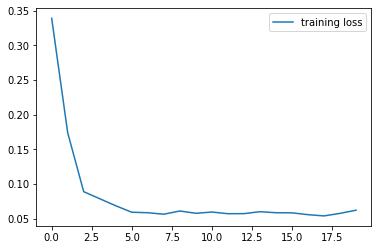

In [ ]:
# plot history
plt.plot(history.history['loss'], label='training loss')
plt.legend()
plt.show()

In [ ]:
# Predict on the test set
y_pred = model.predict(X_test)
y_pred.shape

(56, 1)

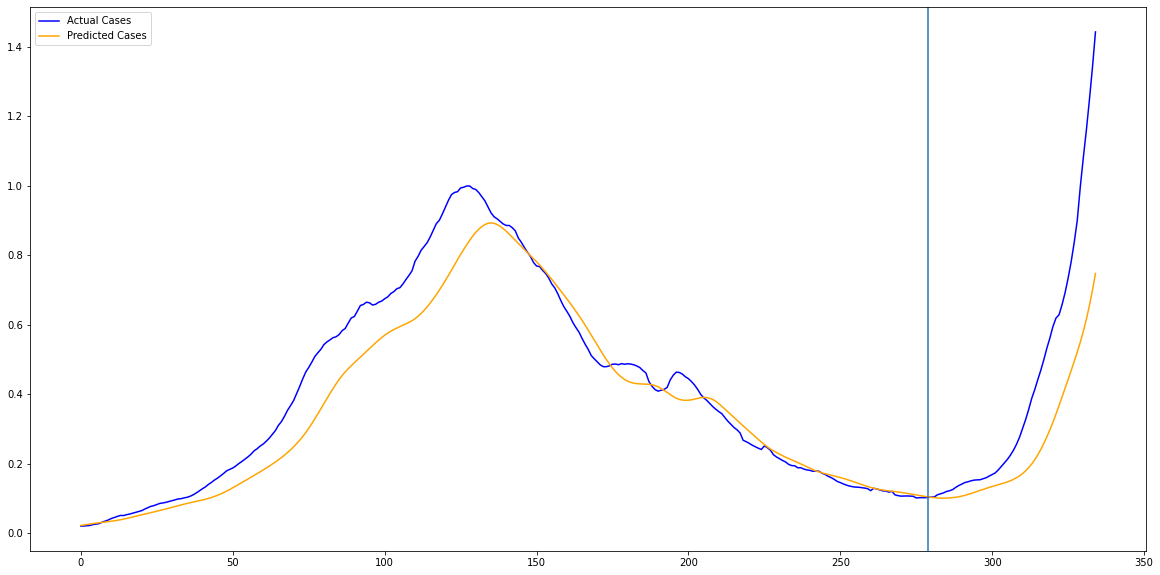

In [ ]:
# Plot scaled visualizations of test and train
plt.figure(figsize=(20,10))
act = pd.concat([y_train, y_test]).reset_index(drop=True)
y_train_pred = pd.DataFrame(model.predict(X_train))
y_pred = pd.DataFrame(y_pred)
pred = pd.concat([y_train_pred, y_pred]).reset_index(drop=True)
plt.plot(act, color='blue', label="Actual Cases")
plt.plot(pred, color='orange', label="Predicted Cases")
plt.axvline(x=pred.shape[0]+test_num)
plt.legend()
wandb.log({"actual_vs_predicted": wandb.Image(plt)})
plt.show()

In [ ]:
"""In order to study the impact of mobility data, uncomment below"""
# train_ts_copy = train_ts.copy()
# ts_data_scaled_copy = ts_data_scaled.copy()
# for col in ['mobility_driving', 'mobility_walking', 'retail_and_recreation',
#        'grocery_and_pharmacy', 'transit_stations', 'parks',
#        'workplaces']:
#        train_ts_copy[col] -= abs(train_ts_copy[col]*0.25)
#        ts_data_scaled_copy[col] -= abs(ts_data_scaled_copy[col]*0.25)

In [ ]:
# Saving the final predictions for future graphs
# final_pred_df = pd.DataFrame(scalers["scaler_Daily Confirmed"].inverse_transform(y_pred), columns=[timesteps])
# final_pred_df.to_csv("/content/drive/MyDrive/Major Project/LSTM/new_cases_"+str(timesteps)+".csv", index=False)

In [ ]:
"""In order to study the impact of mobility data, uncomment below"""
# X_train_copy = np.zeros((batch, timesteps, features))
# for i in range(batch):
#   X_train_copy[i] = train_ts_copy[i:i+timesteps]

# print(X_train_copy.shape)
# # y_train = train_ts.loc[:, "Daily Confirmed"][-batch:]
# # print(y_train.shape)

# X_test_copy = np.zeros((batch_test, timesteps, features))
# for i in range(batch_test):
#   X_test_copy[i] = ts_data_scaled_copy[-timesteps-batch_test+i:-batch_test+i]
# print(X_test_copy.shape)

# # y_test = test_ts.loc[:, "Daily Confirmed"][-(batch_test):]
# # print(y_test.shape)

(293, 7, 1)
(49, 7, 1)


In [ ]:
"""In order to study the impact of mobility data, uncomment below, plot graph"""
# plt.figure(figsize=(20,10))
# act = pd.concat([y_train, y_test]).reset_index(drop=True)
# y_train_pred = pd.DataFrame(model.predict(X_train))
# y_pred = pd.DataFrame(model.predict(X_test))
# pred = pd.concat([y_train_pred, y_pred]).reset_index(drop=True)
# ipred = pd.DataFrame(model.predict(X_train_copy))
# y_ip = pd.DataFrame(model.predict(X_test_copy))
# impact = pd.concat([ipred, y_ip]).reset_index(drop=True)
# plt.plot(act, color='blue', label="Actual Cases")
# plt.plot(pred, color='green', label="Reduced Mobility Cases")
# plt.plot(impact, color='orange', label="Predicted Cases")
# plt.axvline(x=pred.shape[0]+test_num)
# plt.legend()
# wandb.log({"reduced_mobility": wandb.Image(plt)})
# plt.show()

In [ ]:
act = pd.DataFrame(act)

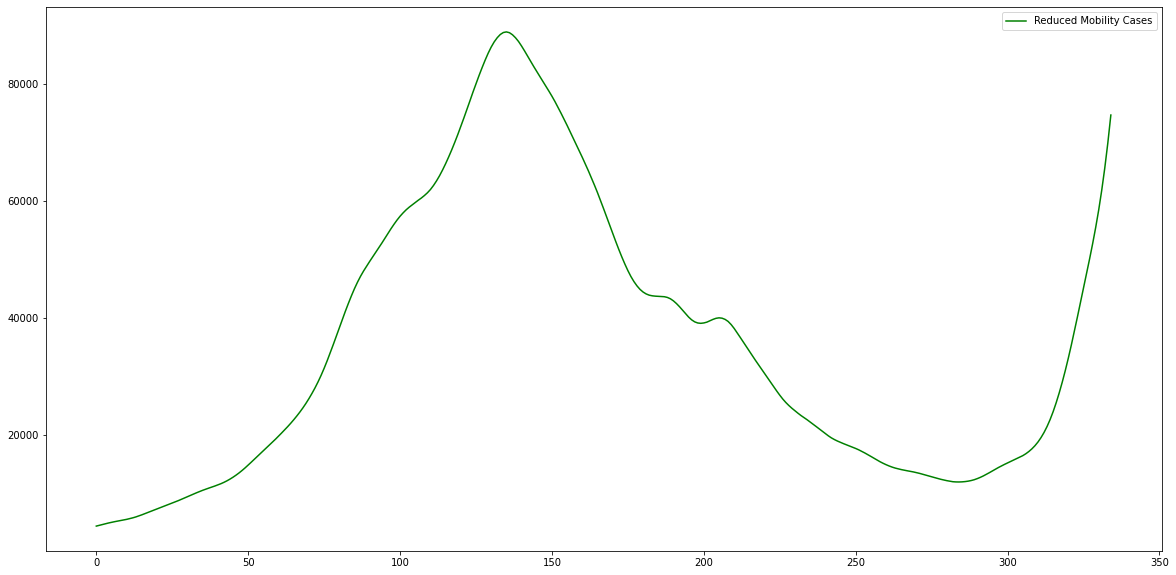

In [ ]:
# Plotting the real values
y_test_inv = scalers['scaler_'+'Daily Confirmed'].inverse_transform(y_test.values.reshape(-1,1))
y_pred_inv = scalers['scaler_'+'Daily Confirmed'].inverse_transform(y_pred)
plt.figure(figsize=(20,10))
plt.plot(y_test_inv, color='blue', label="Actual Cases")
plt.plot(y_pred_inv, color='orange', label="Predicted Cases")
plt.legend()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print("Test MAE: ",mean_absolute_error(y_test_inv,y_pred_inv))
print("Test RMSE: ",mean_squared_error(y_test_inv,y_pred_inv, squared=False))

Test MAE-7days :  14838.065982028973
Test RMSE-7days :  20538.428770081522


In [ ]:
# Forecast if only new_cases are used
if len(columns_list)>1:
  print("Cannot predict for more than one column")
else:
  forecast = y_test.values
  for i in range(30):
    val = forecast[-timesteps:]
    val=np.expand_dims(val,axis=1)
    forecast = np.append(forecast, model.predict(np.expand_dims(val, axis=0)))

  forecast = pd.DataFrame(forecast)

In [ ]:
# Forecast if only new_cases are used, plot on graph
if len(columns_list)>1:
  print("Cannot predict for more than one column")
else:
  plt.figure(figsize=(20,10))

  fc = pd.concat([y_train_pred, y_pred, forecast[-test_num:]]).reset_index(drop=True)
  plt.plot(act, color='blue', label="Actual Cases")
  plt.plot(fc, color='orange', label="Predicted Cases")
  plt.axvline(x=pred.shape[0]+test_num)
  plt.legend()
  wandb.log({"forecast": wandb.Image(plt)})
  plt.show()

In [ ]:
wandb.finish()